## 1. Brief description of the problem and data  

Train labels file have 220,025 entries,Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder, predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label.



In [12]:
import pandas as pd

train_labels_path = 'train_labels.csv'

train_labels = pd.read_csv(train_labels_path)
train_labels.info()
print()
print('train_labels:',train_labels.shape,'\n',train_labels.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB

train_labels: (220025, 2) 
                                          id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


## 2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

Show a few visualizations by with and without cancer. also prief the distribution of train labels by number.

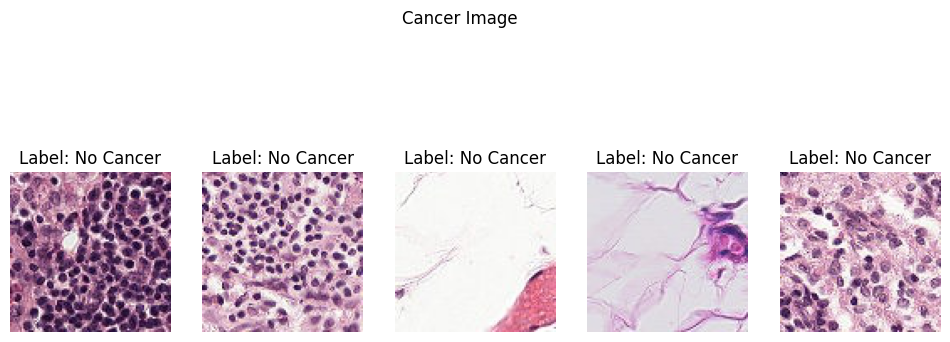

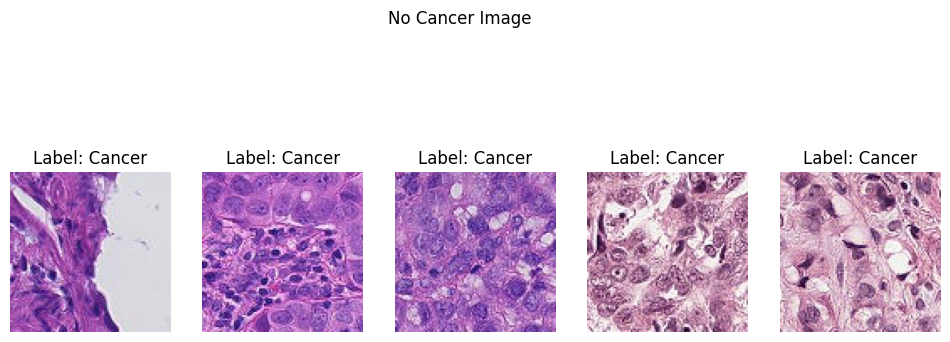

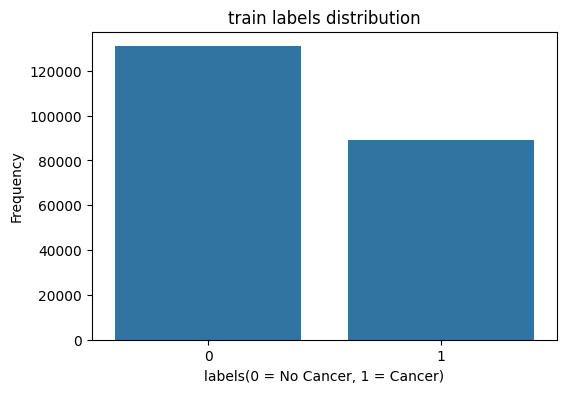

In [13]:
from PIL import Image
from matplotlib import pyplot as plt
import os
import seaborn as sns
import numpy as np

test_folder_path = 'test'
train_folder_path = 'train'
sample_submission_path = 'sample_submission.csv'

dic_label = {0:'No Cancer', 1:'Cancer'}
def display_images(img_ids,labels,title,path):
    plt.figure(figsize=(12, 5))
    for i, (img_id, label) in enumerate(zip(img_ids, labels)):
        img_path = os.path.join(path, img_id + '.tif')
        img = Image.open(img_path)
        plt.subplot(1, len(img_ids), i + 1)
        plt.imshow(img)
        plt.title(f"Label: {dic_label[label]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

display_images(train_labels[train_labels.label == 0].id[10:15],train_labels[train_labels.label == 0].label[10:15],'Cancer Image',train_folder_path)
display_images(train_labels[train_labels.label == 1].id[10:15],train_labels[train_labels.label == 1].label[10:15],'No Cancer Image',train_folder_path)

plt.figure(figsize=(6,4))
sns.countplot(x='label',data=train_labels)
plt.title('train labels distribution')
plt.xlabel('labels(0 = No Cancer, 1 = Cancer)')
plt.ylabel('Frequency')
plt.show()

## 3. DModel Architecture (25 pts)
model being built with 3 convolution follow by one maxpooling layers, then,one flatten layer, and one dense layers. Early stopping and learning rate reduction callbacks are used during training to enhance model performance.


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D,Flatten,Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2


# 1. prepare the data
batch_size = 64
target_size = (32,32)

train_data_tensor = ImageDataGenerator(
    rescale = 1/255,
    validation_split = 0.25
)
def data_prepare(labels):
    # update 'id' to tif filename and convert 'label' to string
    train_labels1 = train_labels.copy()
    train_labels1.id = train_labels1.id.apply(lambda x: x + '.tif')
    train_labels1.label = train_labels1.label.astype(str)
    

    # prepare the train and validation datasets
    train_gen = train_data_tensor.flow_from_dataframe(
        dataframe = train_labels1,
        dictionary = train_folder_path,
        x_col = 'id',
        y_col = 'label',
        target_size = target_size,
        batch_size = batch_size,
        class_mode = 'binary',
        subset = 'training',
        shuffle = True,
    )

    validation_gen = train_data_tensor.flow_from_dataframe(
        dataframe = train_labels1,
        dictionary = train_folder_path,
        x_col = 'id',
        y_col = 'label',
        target_size = target_size,
        batch_size = batch_size,
        class_mode = 'binary',
        subset = 'validation',
        shuffle = True,
    )
    return train_gen, validation_gen

train_gen,validation_gen = data_prepare(train_labels)

Found 0 validated image filenames belonging to 0 classes.


/Users/jms/Library/Python/3.10/lib/python/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 220025 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


Found 0 validated image filenames belonging to 0 classes.


/Users/jms/Library/Python/3.10/lib/python/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 220025 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


In [47]:
from tensorflow.keras.layers import Input
model = Sequential([
    Input(shape=(32,32,3)),
    Conv2D(32,(3,3),activation='relu'),
    MaxPool2D(2,2),
    Conv2D(64,(3,3),activation='relu'),
    MaxPool2D(2,2),
    Conv2D(128,(3,3),activation='relu'),
    MaxPool2D(2,2),
    Flatten(),
    Dense(256,activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
reduce_1r = ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=2,min_lr=0.001)

history = model.fit(
    train_gen,
    # step_per_epoch=train_gen.samples//batch_size,
    validation_data=validation_gen,
    validation_steps=validation_gen.samples//batch_size,
    epochs=10,
    callbacks=[early_stopping,reduce_1r]
)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,833 (878.25 KB)

 Trainable params: 224,833 (878.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/Users/jms/Library/Python/3.10/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2579/2579 ━━━━━━━━━━━━━━━━━━━━ 107s 41ms/step - accuracy: 0.7672 - loss: 0.4959 - val_accuracy: 0.8232 - val_loss: 0.4034 - learning_rate: 0.0010
Epoch 2/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 86s 33ms/step - accuracy: 0.8161 - loss: 0.4088 - val_accuracy: 0.8333 - val_loss: 0.3674 - learning_rate: 0.0010
Epoch 3/10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2579/2579 ━━━━━━━━━━━━━━━━━━━━ 106s 41ms/step - accuracy: 0.8318 - loss: 0.3803 - val_accuracy: 0.8392 - val_loss: 0.3657 - learning_rate: 0.0010
Epoch 4/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 89s 35ms/step - accuracy: 0.8394 - loss: 0.3670 - val_accuracy: 0.9667 - val_loss: 0.2107 - learning_rate: 0.0010
Epoch 5/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 111s 43ms/step - accuracy: 0.8443 - loss: 0.3563 - val_accuracy: 0.8458 - val_loss: 0.3570 - learning_rate: 0.0010
Epoch 6/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 85s 33ms/step - accuracy: 0.8481 - loss: 0.3470 - val_accuracy: 0.7667 - val_loss: 0.4326 - learning_rate: 0.0010
Epoch 7/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 107s 42ms/step - accuracy: 0.8535 - loss: 0.3365 - val_accuracy: 0.8501 - val_loss: 0.3411 - learning_rate: 0.0010


## 4. Results and Analysis  

try Adam and RSMProp, also with and with dropout, the result as follow chat, the RSMProp performs little better,the dropout helps short the training time


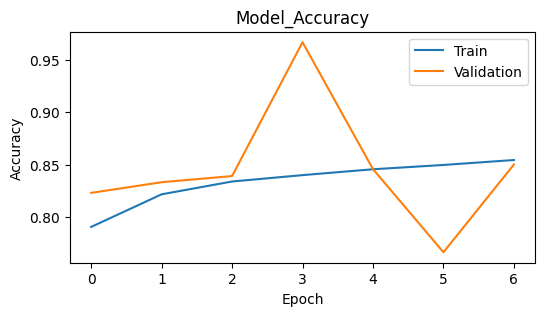

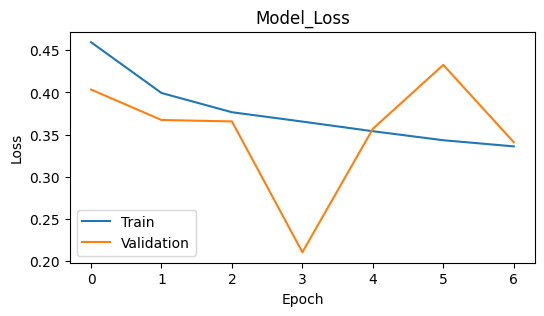

In [48]:
plt.figure(figsize=(6,3))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model_Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'])

plt.figure(figsize=(6,3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model_Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation'])

In [62]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['accuracy'])
history1 = model.fit(
    train_gen,
    validation_data=validation_gen,
    validation_steps=validation_gen.samples//batch_size,
    epochs=10,
    callbacks=[early_stopping,reduce_1r])

Epoch 1/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 113s 44ms/step - accuracy: 0.8438 - loss: 0.3631 - val_accuracy: 0.8500 - val_loss: 0.3447 - learning_rate: 0.0010
Epoch 2/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 85s 33ms/step - accuracy: 0.8472 - loss: 0.3537 - val_accuracy: 0.8667 - val_loss: 0.3185 - learning_rate: 0.0010
Epoch 3/10


2024-09-13 11:43:37.057605: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2579/2579 ━━━━━━━━━━━━━━━━━━━━ 105s 41ms/step - accuracy: 0.8495 - loss: 0.3503 - val_accuracy: 0.8540 - val_loss: 0.3542 - learning_rate: 0.0010


In [74]:
print(train_gen,(model.predict(train_gen)>0.5).astype("int32"))

2579/2579 ━━━━━━━━━━━━━━━━━━━━ 74s 29ms/step
<keras.src.legacy.preprocessing.image.DataFrameIterator object at 0x152064f40> [[1]
 [0]
 [1]
 ...
 [0]
 [1]
 [0]]


In [67]:
model1 = Sequential([
    Input(shape=(32,32,3)),
    Conv2D(32,(3,3),activation='relu'),
    MaxPool2D(2,2),
    Conv2D(64,(3,3),activation='relu'),
    MaxPool2D(2,2),
    Conv2D(128,(3,3),activation='relu'),
    MaxPool2D(2,2),
    Flatten(),
    Dense(256,activation='relu'),
    # Dropout(0.5),
    Dense(1,activation='sigmoid')
])

# model1.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['accuracy'])
model1.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['accuracy'])
model1.summary()
history1 = model1.fit(
    # data_prepare(train_labels)[0],
    train_gen,
    # validation_data=data_prepare(train_labels)[1],
    validation_data=validation_gen,
    validation_steps=validation_gen.samples//batch_size,
    epochs=10,
    callbacks=[early_stopping,reduce_1r])

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_71 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,833 (878.25 KB)

 Trainable params: 224,833 (878.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 112s 43ms/step - accuracy: 0.7566 - loss: 0.5060 - val_accuracy: 0.7901 - val_loss: 0.4617 - learning_rate: 0.0010
Epoch 2/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 85s 33ms/step - accuracy: 0.8109 - loss: 0.4192 - val_accuracy: 0.8333 - val_loss: 0.3919 - learning_rate: 0.0010
Epoch 3/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 105s 41ms/step - accuracy: 0.8254 - loss: 0.3940 - val_accuracy: 0.8394 - val_loss: 0.3679 - learning_rate: 0.0010


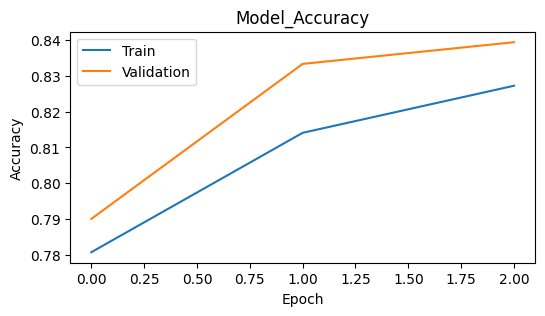

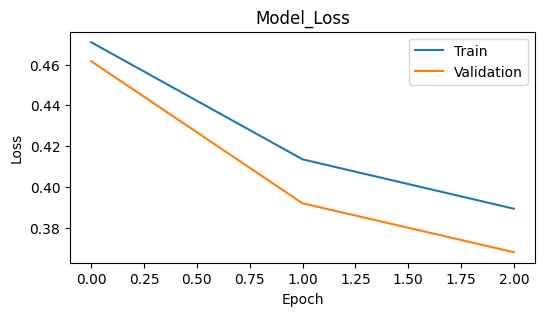

In [68]:
plt.figure(figsize=(6,3))
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model_Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'])

plt.figure(figsize=(6,3))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model_Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation'])

## 5. Conclusion

try 3 layers convolution follow the maxpool, use Adam and RSMProp to evaluate the outcome, the RSMProp train quicker but potentially overfit, might to use more slow learning rate can get even more better result.


In [1]:
# Prepare test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'id': os.listdir(test_folder_path)}),
    directory=test_folder_path,
    x_col='id',
    y_col=None,
    target_size=target_size,
    batch_size=1,
    class_mode=None,
    shuffle=False
)

# Predict on test data
test_generator.reset()

predictions = model.predict(test_generator, steps=test_generator.samples)

# Prepare the submission DataFrame
filenames = test_generator.filenames

ids = [filename.split('.')[0] for filename in filenames]
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)

submission_df = pd.DataFrame({
    'id': ids,
    'label': predicted_labels
})

# Save submission.csv
submission_df.to_csv('submission.csv', index=False)

print("submission.csv file has been created successfully!")

NameError: name 'ImageDataGenerator' is not defined